### III. Feature Selection  and Algorithm improvement.

In this part,I shall work to improve the existing model. How?

How? 

- First I will do a feature selection process, starting with basic fitering methods, plus univariate RMSE and Lasso selection
- I will improve the model by tunning its hyperparameters

In [1]:
# import libraries
import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import xgboost as xgb
from sklearn.metrics import roc_auc_score, r2_score

from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, SelectPercentile

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.feature_selection import f_classif, f_regression
from sklearn.metrics import mean_squared_log_error

from sklearn.linear_model import Ridge, Lasso, LogisticRegression

from sklearn.feature_selection import SelectFromModel

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%matplotlib inline

In [2]:
# Merge the two datasets
X_train=pd.read_csv('X_train.csv',sep= ',')
X_train.shape

(174, 27)

In [3]:
X_test=pd.read_csv('X_test.csv',sep= ',')
X_test.shape

(31, 27)

In [4]:
# Merge the two datasets
y_train=pd.read_csv('y_train.csv',sep= ',')
y_train.shape

(174, 1)

In [5]:
# Merge the two datasets
y_test=pd.read_csv('y_test.csv',sep= ',')
y_test.shape

(31, 1)

In [6]:
# I keep a copy of the dataset with all the variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_original = X_train.copy()
X_test_original = X_test.copy()

**2) Features Selection (Basic filter methods + Lasso)**

#### 2.1 Remove constant 

In [7]:
# Remove constant features
constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]

X_train.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((174, 27), (31, 27))

#### 2.2 Remove quasi constant features

In [8]:
# Remove quasi constant features
sel = VarianceThreshold(
    threshold=0.01)  # 0.1 indicates 99% of observations approximately

sel.fit(X_train)  # fit finds the features with low variance

sum(sel.get_support()) # how many not quasi-constant?

27

In [9]:
features_to_keep = X_train.columns[sel.get_support()]

In [10]:
# we can then remove the features like this
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((174, 27), (31, 27))

In [11]:
# sklearn transformations lead to numpy arrays
# here I transform the arrays back to dataframes
# please be mindful of getting the columns assigned
# correctly

X_train= pd.DataFrame(X_train)
X_train.columns = features_to_keep

X_test= pd.DataFrame(X_test)
X_test.columns = features_to_keep

#### 2.3 Remove Duplicated Features

In [12]:
# Remove duplicated features
# check for duplicated features in the training set
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20


1

In [13]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((174, 26), (31, 26))

In [14]:
# I keep a copy of the dataset except constant and duplicated variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_basic_filter = X_train.copy()
X_test_basic_filter = X_test.copy()

In [15]:
# Remove correlated features
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.8)
print('correlated features: ', len(set(corr_features)) )

correlated features:  4


In [16]:
# removed correlated  features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((174, 22), (31, 22))

In [17]:
# keep a copy of the dataset at  this stage
X_train_corr = X_train.copy()
X_test_corr = X_test.copy()

#### 2.4 Remove features using univariate RMSE

In [18]:
#Remove features using mse
# for each feature of the train set
mse_values = []
for feature in X_train.columns:
    clf = DecisionTreeRegressor()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict(X_test[feature].fillna(0).to_frame())
    mse_values.append(mean_squared_error(y_test, y_scored))

In [19]:
# let's add the variable names and order it for clearer visualisation
mse_values = pd.Series(mse_values)
mse_values.index = X_train.columns
mse_values.sort_values(ascending=False)

num_of_cylinders             5.965693e+07
curb_weight                  4.043047e+07
normalized_losses_NA         3.736175e+07
stroke_ordered               3.711556e+07
horsepower_ordered           3.370617e+07
make_id                      3.152116e+07
bore                         2.947477e+07
normalized_losses            2.823884e+07
num_of_doors                 2.683094e+07
drive_wheels                 2.660320e+07
engine_location              2.539434e+07
fuel_type                    2.528444e+07
aspiration                   2.495793e+07
peak_rpm                     2.475404e+07
body_style                   2.440696e+07
engine_type                  2.433417e+07
symboling                    2.143425e+07
fuel_system                  2.057597e+07
compression_ratio_ordered    2.050025e+07
wheel_base_ordered           2.033272e+07
height                       1.848688e+07
city_mpg                     1.601119e+07
dtype: float64

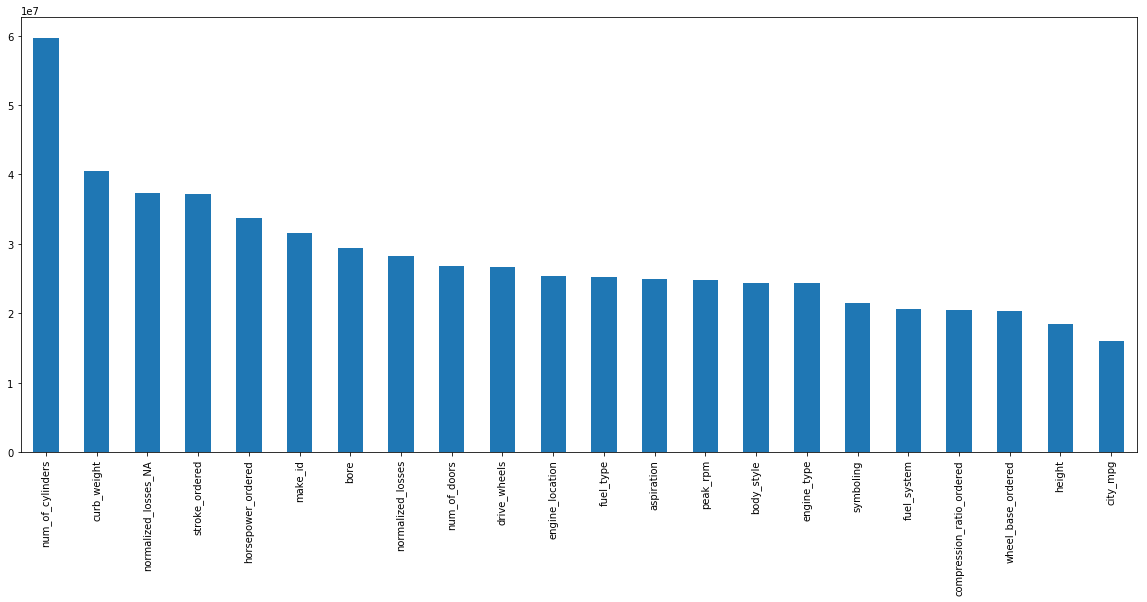

In [20]:
mse_values.sort_values(ascending=False).plot.bar(figsize=(20,8))

In [21]:
X_train.shape

(174, 22)

#### 2.5 Select features usign Lasso

In [22]:
sel_ = SelectFromModel(Lasso(alpha=100))
sel_.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=100, copy_X=True, fit_intercept=True,
                                max_iter=1000, normalize=False, positive=False,
                                precompute=False, random_state=None,
                                selection='cyclic', tol=0.0001,
                                warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [23]:
sel_.get_support()

array([ True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [24]:
# make a list with the selected features and print the outputs
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 22
selected features: 20
features with coefficients shrank to zero: 2


In [25]:
# remove features with zero coefficient from dataset
# and parse again as dataframe (output of sklearn is
# numpy array)
X_train_lasso = pd.DataFrame(sel_.transform(X_train))
X_test_lasso = pd.DataFrame(sel_.transform(X_test))

# add the columns name
X_train_lasso.columns = X_train.columns[(sel_.get_support())]
X_test_lasso.columns = X_train.columns[(sel_.get_support())]


In [26]:
X_train = X_train_lasso
X_test = X_test_lasso

In [27]:
X_train.shape

(174, 20)

In [28]:
X_test.shape

(31, 20)

### 3. Algorithm testing

Remember the best algorithm was Ridge regression.

In [29]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
# All features
Ridge = Ridge()
Ridge.fit(X_train,y_train)
Ridge_predictions = Ridge.predict(X_test)
print (' REDUCED features Ridge Regression RMSE is', np.sqrt(mean_squared_error(y_test, Ridge_predictions)))




 REDUCED features Ridge Regression RMSE is 3195.141631069943


In [30]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
# All features
Ridge = Ridge()
Ridge.fit(X_train_original,y_train)
Ridge_predictions_or = Ridge.predict(X_test_original)
print (' Initial features Ridge Regression RMSE is', np.sqrt(mean_squared_error(y_test, Ridge_predictions_or)))



 Initial features Ridge Regression RMSE is 3774.5442779356827


Clearly, we have improved our model.
- We have reduced the feature space from 27 to 20
- Improved RMSE from 3774 to 3195

In [31]:
import numpy as np
from sklearn import datasets
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# prepare a range of alpha values to test
alphas = np.array([100,98])
# create and fit a ridge regression model, testing each alpha
model = Ridge()
search = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), scoring='neg_mean_squared_error')
search.fit(X_train, y_train)
# summarize the results of the grid search
print(search.best_score_)
print(search.best_params_)


-13733077.315839699
{'alpha': 98}


In [32]:
# Now I try to replicate my model with above found hyperparameters
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
# All features
Ridgebest = Ridge(alpha=98)
Ridgebest.fit(X_train,y_train)
Ridgebest_predictions = Ridgebest.predict(X_test)
print (' Hyperparameter tuned Ridge Regression RMSE is', np.sqrt(mean_squared_error(y_test, Ridgebest_predictions)))




 Hyperparameter tuned Ridge Regression RMSE is 2455.464129805275


### 4. Conclusion

Thanks to Feature Selection we obtained:
    - Reduced feature set from 27 to 20
    - Improved RMSE results from 3774 to 3195

Thanks to Hyperparmaeter tuning, we further reduced RMSE results:
    - From 3195 to 2455

The model has been created with a rather small dataset, it could certainly be improved by increasing the dataet.


In [33]:
# Saving best model
from sklearn.externals import joblib
from joblib import dump, load

In [34]:
dump(Ridgebest,'lm.joblib') 

['lm.joblib']

In [35]:
def print_metrics(y_train, y_test, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_train, y_test)
    r2_adj = r2 - (n_parameters - 1)/(y_train.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_train, y_test)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_train, y_test))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_train, y_test)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_train, y_test)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
   
y_score = Ridgebest.predict(X_test) 
print_metrics(y_test, y_score, 40)

Mean Square Error      = 6029304.092760378
Root Mean Square Error = 2455.464129805275
Mean Absolute Error    = 1623.5029814194017
Median Absolute Error  = 1099.9827243069276
R^2                    = 0.7001486926356962
Adjusted R^2           = 1.9995043578810123


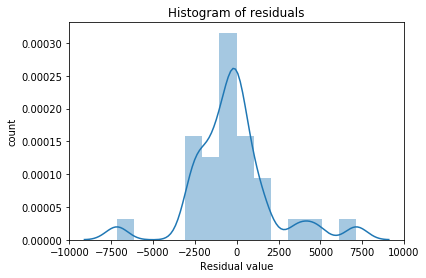

In [36]:
def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test, y_score)
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    
hist_resids(y_test, y_score) 

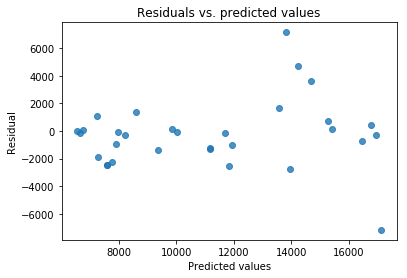

In [37]:
def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test, y_score)
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')

resid_plot(y_test, y_score)

Looking at the residuals vs the predicted values, we can see all values are around zero, except for a few high and low values, probably due to outeliers.

Given the dataset was so small, I could not afford to remove the outliers and thus I had to pre-process them. Otherwise, I could have separated them and analyzed them on a different notebook. 

Visualizations provided of the dataset on a different notebook show that there are some models, probably sport and luxury cars on one end, and very low consumption cars that create outliers in the dataset. These are the outliers to be examined separately, as they show different trends in price vs variables. For example, price vs fuel consumption (normally it decreases, except for luxury cars) and so on. 